<a href="https://colab.research.google.com/github/avncalst/drone_cnn/blob/master/quantObjectDet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Custom object detection notebook**



In [ ]:
# Support for TF1.x
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# create symbolic link
!ln -s "drive/MyDrive/Colab Notebooks/Tensorflow" "./Tensorflow"
!dir

drive  sample_data  Tensorflow


In [ ]:
# delete symbolic link
!rm "./Tensorflow"

In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2431, done.
remote: Counting objects: 100% (2431/2431), done.
remote: Compressing objects: 100% (2033/2033), done.
remote: Total 2431 (delta 579), reused 1378 (delta 370), pack-reused 0
Receiving objects: 100% (2431/2431), 30.82 MiB | 37.62 MiB/s, done.
Resolving deltas: 100% (579/579), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf1/setup.py .
python -m pip install .


Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1624253 sha256=83727efcb58e80a4af67fe4d9bfc41aa6b7b4fa60dbe5bef44e50b9eede57520
  Stored in directory: /tmp/pip-ephem-wheel-cache-g88rpuum/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


# 0. Setup Paths + load modules

In [ ]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
# CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
# CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'
TFLITE = 'Tensorflow/tflite'
CUSTOM_MODEL_NAME = 'quant_model' 


import cv2 # if imported !labelImg not working
import os
import time
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
from IPython.display import clear_output, Image, display

%matplotlib inline

# 1. Capture images from webcam

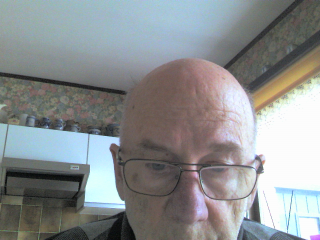

saving image: 119
count%10: 0
pause: q
images saved: Tensorflow/workspace/images/collectedimages


In [ ]:
# imgFolder = 'Tensorflow/workspace/images/img_avc'
imgFolder = IMAGE_PATH + '/collectedimages'
cap = cv2.VideoCapture(0)
width = 640  # WIDTH OF THE IMAGE
height = 480  # HEIGHT OF THE IMAGE
countStart = 100 # start numbering
count = countStart # start numbering
pause = False

while not pause:
    
    ret, myFrame = cap.read()
    img = cv2.resize(myFrame, (width, height))
    imag = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    filename = 'image'+ '_' +str(count) + '.jpg'
    imag = cv2.resize(imag,(320,240))
    time.sleep(1)
    clear_output(wait=False)
    # plt.imshow(imag)
    # plt.show()
    display(PIL.Image.fromarray(imag))
    
    if count > countStart+5:
        cv2.imwrite(os.path.join(imgFolder,filename),img)
        print('saving image:',count)
    count += 1
    print('count%10:',count%20)
    if not (count%20):
        pause = True
        pause = input('Press "enter" to continue or "q" to quit')
        print('pause:',pause)

print('images saved:',imgFolder) 
cap.release()



# 2. Label images train & test folder
remark: if cv2 imported in jupyter notebook -> !labelImg not working. Restart Kernel.

Copy captures images files to train & test folder. Label images with labelImg. To generate xml-files with no label (background images), press "verify image".

In [ ]:
source = IMAGE_PATH+'/collectedimages'
files = os.listdir(source)
num = len(files)
print('number of files:',num)
procent = 0.9
numpro = int(num*procent)
print('procent files:',numpro)
foldertrain = os.path.join(ANNOTATION_PATH, 'testTrain')
if not os.path.exists(foldertrain):
        os.makedirs(foldertrain)
foldertest = os.path.join(ANNOTATION_PATH, 'testTest')
if not os.path.exists(foldertest):
        os.makedirs(foldertest)

for idx, fil in enumerate(files):
    
    if idx < numpro:
        shutil.copy(source + '/' + fil, foldertrain)
        # print(fil) 
    else:
        shutil.copy(source + '/' + fil, foldertest)
        print(fil) 

print('files copied to:',numpro,foldertrain)
print('files copied to:',num-numpro,foldertest)


number of files: 18
procent files: 16
image_177.jpg
image_165.jpg
files copied to: 16 Tensorflow/workspace/annotations/testTrain
files copied to: 2 Tensorflow/workspace/annotations/testTest


In [ ]:
!labelImg

# 3. Create Label Map

In [ ]:
# labels = [{'name':'Cap', 'id':1}, {'name':'noCap', 'id':2}]
labels = [{'name':'avc', 'id':1}]

with open(ANNOTATION_PATH + '/label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 4. Create TF records
use modified generate_tfrecord.py to incorporate background images

In [ ]:
!python3 {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {ANNOTATION_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -c {ANNOTATION_PATH + '/train.csv'}  -o {ANNOTATION_PATH + '/train.record'}
!python3 {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{ANNOTATION_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'}  -c {ANNOTATION_PATH + '/test.csv'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the CSV file: Tensorflow/workspace/annotations/train.csv
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record
Successfully created the CSV file: Tensorflow/workspace/annotations/test.csv


# 5. Verification: plotting randomly selected images

In [ ]:
# background images: class=xmin=ymin=xmax=ymax=0

img_data = pd.read_csv(ANNOTATION_PATH + '/train.csv')
# img_data.loc[img_data['class'] == '-1', 'xmin'] = 0
# img_data.loc[img_data['class'] == '-1', 'ymin'] = 0
# img_data.loc[img_data['class'] == '-1', 'xmax'] = 0
# img_data.loc[img_data['class'] == '-1', 'ymax'] = 0
# img_data.loc[img_data['class'] == '-1', 'class'] = 0

img_data = img_data.replace('-1',0)
img_data = img_data.replace(-1,0)
img_data.head()
img_data.tail()



,filename,width,height,class,xmin,ymin,xmax,ymax
75,image_38.jpg,640,480,avc,89,191,178,309
76,image_64.jpg,640,480,avc,253,84,424,314
77,image_31.jpg,640,480,avc,189,169,288,295
78,image_160.jpg,640,480,0,0,0,0,0
79,image_21.jpg,640,480,avc,198,206,424,480


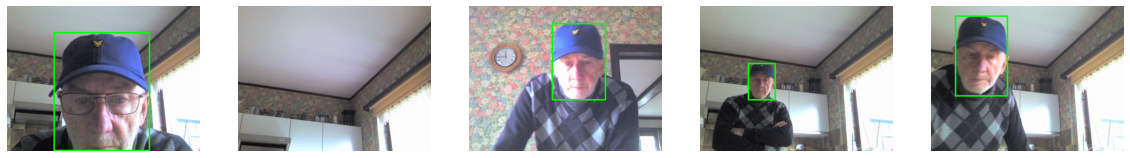

In [ ]:
# Create a Matplotlib figure
# img_directory = 'Tensorflow/workspace/images/img_avc/'
import random

plt.figure(figsize=(20,20));

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, 70), 5)
for iteration, i in enumerate(random_range):

    # Bounding box of each image
    x1, y1, x2, y2 = img_data.iloc[i][['xmin','ymin','xmax','ymax']].values;

    # read image to visualize
    imag = ANNOTATION_PATH+'/train/'+img_data.iloc[i]['filename']
    # print(imag)
    # print(i)
    image = cv2.imread(imag)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # print(imag)

    # Draw bounding boxes on the image
    cv2.rectangle(image, (int(x1),int(y1)),
          (int(x2),int(y2)),
                  (0,255,0),
                  3);
    
    # Clip the values to 0-1 and draw the sample of images
    # image = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, iteration+1);
    plt.imshow(image);
    plt.axis('off');

# 6. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [ ]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
#!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

In [ ]:
!cd Tensorflow && git clone https://github.com/tensorflow/models

# 7. Copy Model Config to Training Folder

In [ ]:
CUSTOM_MODEL_NAME = 'quant_model' 

In [ ]:
!mkdir {'Tensorflow/workspace/models/'+CUSTOM_MODEL_NAME}
!cp {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_quantized_300x300_coco/pipeline_quant_ml.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

mkdir: cannot create directory ‘Tensorflow/workspace/models/quant_model’: File exists


# 8. Update Config For Transfer Learning

In [ ]:
import tensorflow as tf
print(tf.__version__)
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

1.15.2


In [ ]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline_quant_ml.config'
print(CONFIG_PATH)

Tensorflow/workspace/models/quant_model/pipeline_quant_ml.config


In [ ]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [ ]:
config

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "Tensorflow/workspace/annotations/label_map.pbtxt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "Tensorflow/workspace/annotations/test.record"
 },
 'eval_input_configs': [label_map_path: "Tensorflow/workspace/annotations/label_map.pbtxt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "Tensorflow/workspace/annotations/test.record"
 }
 ],
 'model': ssd {
   num_classes: 2
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.00999999977648258

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = 1
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_quantized-300x300_coco/model.ckpt'
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                          
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                     
    f.write(config_text)   

# 9. Train the model

In [ ]:
pipeline_config=MODEL_PATH + '/' + CUSTOM_MODEL_NAME + '/pipeline_quant_ml.config'
model=MODEL_PATH + '/' + CUSTOM_MODEL_NAME
print(pipeline_config)
print(model)
!dir

Tensorflow/workspace/models/quant_model/pipeline_quant_ml.config
Tensorflow/workspace/models/quant_model
drive  models  sample_data  Tensorflow


In [ ]:
!python Tensorflow/models/research/object_detection/model_main.py --model_dir=Tensorflow/workspace/models/quant_model --pipeline_config_path=Tensorflow/workspace/models/quant_model/pipeline_quant_ml.config --num_train_steps=6000

W0225 17:09:52.518323 140300981909376 model_lib.py:813] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 6000
I0225 17:09:52.518555 140300981909376 config_util.py:552] Maybe overwriting train_steps: 6000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0225 17:09:52.518654 140300981909376 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0225 17:09:52.518735 140300981909376 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0225 17:09:52.518813 140300981909376 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0225 17:09:52.518911 140300981909376 model_lib.py:829] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_t

# 10. Create Frozen graph

In [ ]:
!python3 Tensorflow/models/research/object_detection/export_tflite_ssd_graph.py     --pipeline_config_path=Tensorflow/workspace/models/quant_model/pipeline_quant_ml.config     --trained_checkpoint_prefix=Tensorflow/workspace/models/quant_model/model.ckpt-6000    --output_directory=Tensorflow/workspace/models/quant_model --add_postprocessing_op=true

Instructions for updating:
Please use `layer.__call__` method instead.
W0225 17:25:48.623490 140548847503232 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0225 17:25:50.606268 140548847503232 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0225 17:25:50.634464 140548847503232 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0225 17:25:50.661936 140548847503232 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

# 11. Convert Frozengraph to tflite model

In [ ]:
!tflite_convert --graph_def_file=Tensorflow/workspace/models/quant_model/tflite_graph.pb --output_file=Tensorflow/workspace/models/quant_model/detect.tflite --output_format=TFLITE \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3'  \
--inference_type=QUANTIZED_UINT8 \
--mean_values=128 \
--std_dev_values=127 \
--change_concat_input_ranges=false \
--allow_custom_ops

2021-02-25 17:26:49.837064: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-02-25 17:26:49.865376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-25 17:26:49.865992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2021-02-25 17:26:49.866276: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-02-25 17:26:49.867962: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-02-25 17:26:49.869809: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-

# 12. Convert tflite model to edgetpu
inference with converted model does not perform well on ssd_mobilenet

In [ ]:
!edgetpu_compiler Tensorflow/workspace/models/quant_model/detect.tflite 
# !edgetpu_compiler --show_operations {save_path + 'model.tflite'} -o Tensorflow/tflite/

utput model: Tensorflow/tflite/convert_quant_edgetpu.tflite
Output size: 3.88MiB
On-chip memory used for caching model parameters: 3.21MiB
On-chip memory remaining for caching model parameters: 4.51MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 167
Operation log: Tensorflow/tflite/convert_quant_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 117
Number of operations that will run on CPU: 50

Operator                       Count      Status

QUANTIZE                       4          More than one subgraph is not supported
QUANTIZE                       6          Mapped to Edge TPU
CONV_2D                   

# 13. Mount drive en download folder from Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 14. Zip and download folder

In [ ]:
!zip -r /content/file.zip /content/Tensorflow/workspace/models/quant_model

  adding: content/Tensorflow/workspace/models/quant_model/ (stored 0%)
  adding: content/Tensorflow/workspace/models/quant_model/pipeline_quant_ml.config (deflated 71%)
  adding: content/Tensorflow/workspace/models/quant_model/events.out.tfevents.1614273012.717d42db96aa (deflated 93%)
  adding: content/Tensorflow/workspace/models/quant_model/graph.pbtxt (deflated 97%)
  adding: content/Tensorflow/workspace/models/quant_model/model.ckpt-0.data-00000-of-00001 (deflated 54%)
  adding: content/Tensorflow/workspace/models/quant_model/model.ckpt-0.index (deflated 80%)
  adding: content/Tensorflow/workspace/models/quant_model/checkpoint (deflated 65%)
  adding: content/Tensorflow/workspace/models/quant_model/model.ckpt-0.meta (deflated 93%)
  adding: content/Tensorflow/workspace/models/quant_model/model.ckpt-4684.data-00000-of-00001 (deflated 7%)
  adding: content/Tensorflow/workspace/models/quant_model/model.ckpt-4684.index (deflated 73%)
  adding: content/Tensorflow/workspace/models/quant_m

In [ ]:
from google.colab import files
files.download('file.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>